## DA - Project 3
* Oskar Szudzik 148245,
* Krystian Moras 148243

In [6]:
import numpy as np
import pandas as pd

data = pd.read_csv('monodata/breast cancer.csv', header=None)
data = data.drop_duplicates()

criteria_nr = 7
target_map = {1: 0, 2: 1}
data[criteria_nr] = data[criteria_nr].apply(lambda x: target_map[x])

data_input = data.iloc[:, :criteria_nr]
data_target = data[criteria_nr]

data_input, data_target

(       0         1      2    3    4    5    6
 0    1.0  0.500000  0.000  1.0  1.0  1.0  0.0
 1    0.5  0.500000  0.000  0.0  0.0  1.0  0.0
 2    0.5  0.833333  0.000  0.0  0.5  0.0  0.0
 3    1.0  0.833333  0.000  1.0  1.0  1.0  1.0
 4    1.0  1.000000  0.125  1.0  0.5  0.0  0.0
 ..   ...       ...    ...  ...  ...  ...  ...
 270  1.0  1.000000  0.125  1.0  0.5  0.0  1.0
 272  0.5  0.500000  0.000  0.0  1.0  1.0  1.0
 273  0.5  1.000000  0.250  1.0  0.5  0.0  0.0
 274  1.0  0.833333  0.125  1.0  0.5  0.0  1.0
 275  1.0  1.000000  0.250  1.0  0.5  1.0  0.0
 
 [173 rows x 7 columns],
 0      1
 1      0
 2      1
 3      0
 4      1
       ..
 270    0
 272    0
 273    0
 274    0
 275    0
 Name: 7, Length: 173, dtype: int64)

### ML model - XGBoost

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target, test_size=0.2, random_state=667
)

In [9]:
params = {
    "max_depth": criteria_nr * 2,
    "eta": 0.1,
    "nthread": 2,
    "seed": 667,
    "eval_metric": "rmse",
    "monotone_constraints": "(" + ",".join(["1"] * criteria_nr) + ")",
    "n_estimators": 1,
}

model = xgb.XGBClassifier(**params)

_ =model.fit(X_train, y_train)

In [10]:
from helpers import *

In [11]:
y_pred = model.predict(X_train)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_train, predictions)
print("Accuracy train: %.2f%%" % (accuracy * 100.0))

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy test: %.2f%%" % (accuracy * 100.0))


Accuracy train: 71.01%
Accuracy test: 65.71%


<AxesSubplot: >

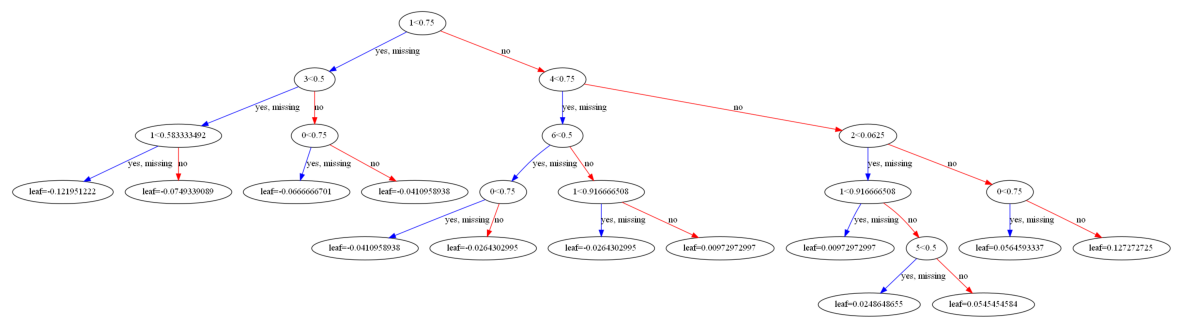

In [12]:
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(model, ax=ax, num_trees=0)

In [13]:
def partial_dependency(booster, X, y, crite = -1):
    grid = np.linspace(0,1,50)
    y_pred = np.zeros(len(grid))
    for i, val in enumerate(grid):
        X_temp = X.copy()
        X_temp[:, f_id] = val
        data = xgb.DMatrix( pd.DataFrame(X_temp) )
        y_pred[i] = np.average(booster.predict(data))

    return grid, y_pred

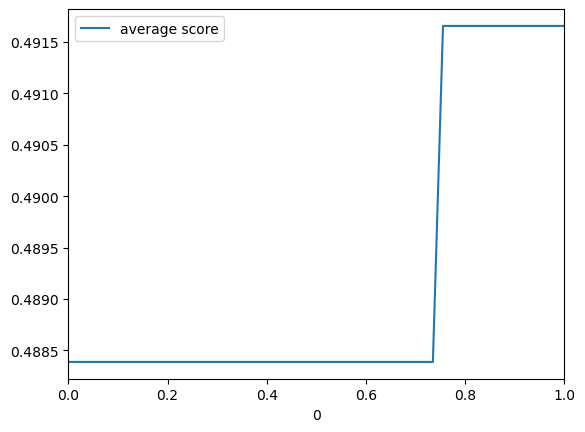

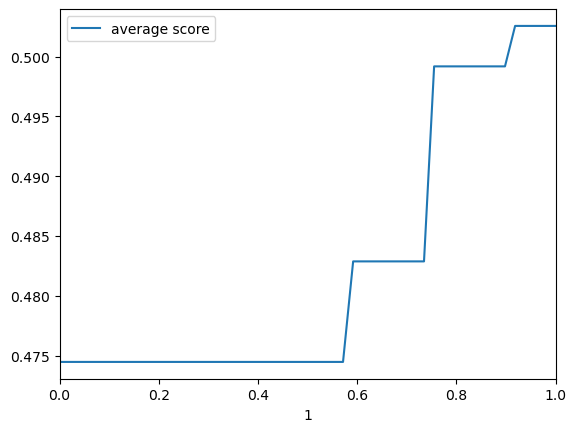

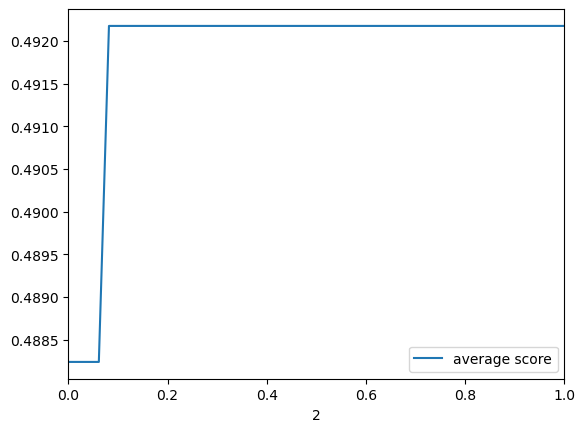

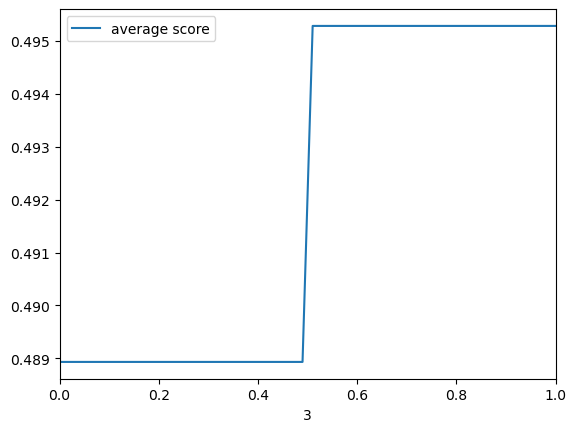

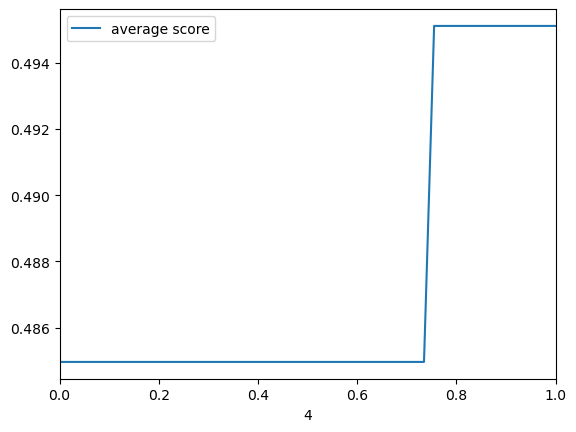

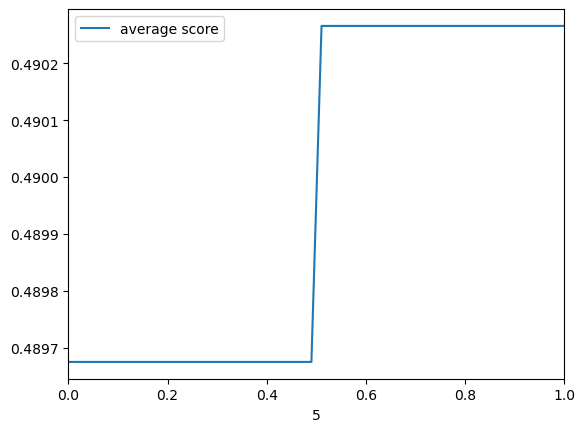

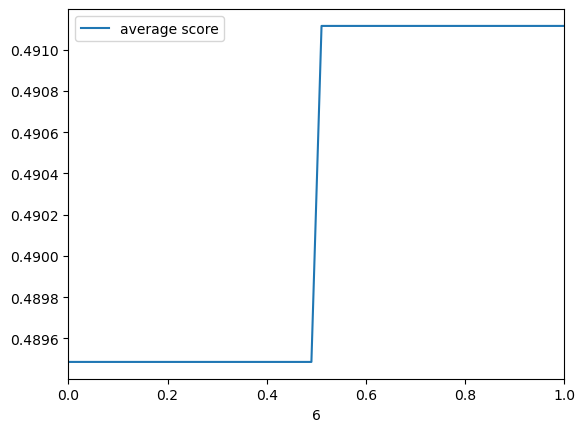

In [14]:
booster = model.get_booster()
grid = np.linspace(0,1,50)
for c in range(criteria_nr):
    y_pred = np.zeros(len(grid))
    for i, val in enumerate(grid):
        X_temp = X_train.values.copy()
        X_temp[:, c] = val
        data = xgb.DMatrix( pd.DataFrame(X_temp) )
        y_pred[i] = np.average(booster.predict(data))
        
    fig, ax = plt.subplots()
    ax.plot(grid, y_pred,  label='average score')
    ax.set_xlim(0, 1)
    ax.set_xlabel(c)
    ax.legend()

In [15]:
booster.get_fscore()

{'0': 3.0, '1': 4.0, '2': 1.0, '3': 1.0, '4': 1.0, '5': 1.0, '6': 1.0}

In [16]:
# TODO: interpretations, explanations, visualizations

TODO: "take 3 alternatives" task

### Neural MCDA method - ANN-UTADIS

In [17]:
from nb_UTA import *

In [18]:
data = pd.read_csv('monodata/breast cancer.csv', header=None)
data = data.drop_duplicates()

criteria_nr = 7
target_map = {1: 0, 2: 1}
data_target = data[criteria_nr].apply(lambda x: target_map[x])
data_input = data.iloc[:, :criteria_nr]
data_input = data_input.values.reshape(-1, 1, criteria_nr)

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values, test_size=0.2, random_state=667
)

In [19]:
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [40]:
PATH = "uta.pt2"
uta = Uta(criteria_nr, 30)

acc, acc_test, auc, auc_test = Train(uta, train_dataloader, test_dataloader, PATH)

print("Accuracy train:\t%.2f%%" % (acc * 100.0))
print("AUC train: \t%.2f%%" % (acc_test * 100.0))
print()
print("Accuracy test:\t%.2f%%" % (auc * 100.0))
print("AUC test: \t%.2f%%" % (auc_test * 100.0))

100%|██████████| 200/200 [00:01<00:00, 154.45it/s]

Accuracy train:	60.87%
AUC train: 	62.86%

Accuracy test:	60.80%
AUC test: 	80.44%


In [35]:
checkpoint = torch.load(PATH)
uta.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [36]:
# TODO: should be working for just uta

def getSimpleInput(val):
    return torch.FloatTensor([[val] * criteria_nr]).view(1, 1, -1).cpu()


hook = Hook(model.method.criterionLayerCombine, append_output)
xs = []
with torch.no_grad():
    for i in range(201):
        val = i / 200.0
        x = getSimpleInput(val)
        xs.append(val)
        uta(x)

outs = np.array(torch.stack(hook.stats)[:, 0].detach().cpu())
outs = model.method.sum_layer.weight.detach().numpy()[0]
outs = outs[::3] - outs[::3][0]
outs = outs / outs[-1].sum()

AttributeError: 'Hook' object has no attribute 'stats'

In [37]:
for i in range(criteria_nr):
    plt.plot(xs, outs[:, i], color="black")
    plt.ylabel("marginal value $u_{0}(a_i)$".format(i + 1), fontsize=14)
    plt.xlabel("performance $g_{0}(a_i)$".format(i + 1), fontsize=14)
    plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

### Neural Network

In [47]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [48]:
data = pd.read_csv('monodata/breast cancer.csv', header=None)
data = data.drop_duplicates()

criteria_nr = 7
target_map = {1: 0, 2: 1}
data_target = data[criteria_nr].apply(lambda x: target_map[x])
data_input = data.iloc[:, :criteria_nr]
data_input = data_input.values.reshape(-1, 1, criteria_nr)

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values, test_size=0.2, random_state=667
)

In [49]:
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [50]:
PATH = "some_nn.pt2"
net = NeuralNetwork(criteria_nr, 30)

acc, acc_test, auc, auc_test = Train(uta, train_dataloader, test_dataloader, PATH)

print("Accuracy train:\t%.2f%%" % (acc * 100.0))
print("AUC train: \t%.2f%%" % (acc_test * 100.0))
print()
print("Accuracy test:\t%.2f%%" % (auc * 100.0))
print("AUC test: \t%.2f%%" % (auc_test * 100.0))

100%|██████████| 200/200 [00:01<00:00, 159.55it/s]

Accuracy train:	60.87%
AUC train: 	60.00%

Accuracy test:	50.00%
AUC test: 	50.00%
